In [1]:
import pandas as pd
import numpy as np
from io import StringIO
import re

import seaborn as sns
import matplotlib.pyplot as plt

import random
from datetime import datetime
from datetime import timedelta
import time
%matplotlib inline

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

Q4. Optimizing memory is more important for longer running jobs then shorter running jobs as the resources are tied up for longer. If jobs are weighted by runtime, what is the average percent of memory used of the requested memory for each group? (i.e., what is the weighted average of memory usage vs. requested memory for each group?)

To do:  
-group data frame by user groups  
-understand sequential jobid numbering (and if that is a proxy for arrays)  
-create new columns for weighted average requested and weighted average used per group  
-focus on "production" partitions (but if there's time, look at others as well)  
-compare required time to used time and completed jobs to failed jobs; is there a buffer around run time? does the job cancel the second that used time exceeded required time?  

In [3]:
accre = pd.read_csv('../data/accre-jobs-2020-clean.csv')

In [4]:
accre.head()

,JOBID,ACCOUNT,USER,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE,STATE,NODELIST,REQMEM_NO,REQMEM_TYPE,REQMEM_PER_CORE,USEDMEM_TYPE,USEDMEM_NO,USEDMEM_PER_CORE,REQTIME_DAY_SEC,REQTIME_T,REQTIME_SEC,USEDTIME_DAY_SEC,USEDTIME_T,USEDTIME_SEC
0,15925210,treviso,arabella,122880Mn,65973.49M,13-18:00:00,13-18:00:28,1,24,production,0:0,COMPLETED,cn1531,122880,Mn,5120.0,M,65973,2748.875000,1123200.0,18:00:00,1188000.0,1123200.0,18:00:28,1188028.0
1,15861126,treviso,arabella,122880Mn,67181.12M,13-18:00:00,12-14:50:56,1,24,production,0:0,COMPLETED,cn1441,122880,Mn,5120.0,M,67181,2799.208333,1123200.0,18:00:00,1188000.0,1036800.0,14:50:56,1090256.0
2,15861125,treviso,arabella,122880Mn,69111.86M,13-18:00:00,13-18:00:20,1,24,production,0:0,COMPLETED,cn1464,122880,Mn,5120.0,M,69111,2879.625000,1123200.0,18:00:00,1188000.0,1123200.0,18:00:20,1188020.0
3,16251645,treviso,arabella,122880Mn,65317.33M,13-18:00:00,12-03:50:32,1,24,production,0:0,COMPLETED,cn1473,122880,Mn,5120.0,M,65317,2721.541667,1123200.0,18:00:00,1188000.0,1036800.0,03:50:32,1050632.0
4,16251646,treviso,arabella,122880Mn,65876.11M,13-18:00:00,13-18:00:03,1,24,production,0:0,COMPLETED,cn1440,122880,Mn,5120.0,M,65876,2744.833333,1123200.0,18:00:00,1188000.0,1123200.0,18:00:03,1188003.0


In [5]:
accre.tail()

,JOBID,ACCOUNT,USER,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE,STATE,NODELIST,REQMEM_NO,REQMEM_TYPE,REQMEM_PER_CORE,USEDMEM_TYPE,USEDMEM_NO,USEDMEM_PER_CORE,REQTIME_DAY_SEC,REQTIME_T,REQTIME_SEC,USEDTIME_DAY_SEC,USEDTIME_T,USEDTIME_SEC
3816285,24173815_8,portabella,vennie,32768Mn,30042.68M,1-00:00:00,00:02:27,1,2,production,0:0,COMPLETED,cn312,32768,Mn,16384.0,M,30042,15021.0,86400.0,00:00:00,86400.0,0.0,00:02:27,147.0
3816286,24173815_9,portabella,vennie,32768Mn,31067.75M,1-00:00:00,00:02:27,1,2,production,0:0,COMPLETED,cn312,32768,Mn,16384.0,M,31067,15533.5,86400.0,00:00:00,86400.0,0.0,00:02:27,147.0
3816287,24173815_10,portabella,vennie,32768Mn,21207.96M,1-00:00:00,00:01:40,1,2,production,0:0,COMPLETED,cn368,32768,Mn,16384.0,M,21207,10603.5,86400.0,00:00:00,86400.0,0.0,00:01:40,100.0
3816288,24173817,boysenberries,hortensia,100000Mn,0,1-00:00:00,00:03:05,1,8,production,0:0,RUNNING,cn1509,100000,Mn,12500.0,NaN,0,0.0,86400.0,00:00:00,86400.0,0.0,00:03:05,185.0
3816289,24173866,horseradish,ariane,20480Mn,0,05:00:00,00:02:05,1,1,production,0:0,RUNNING,cn1131,20480,Mn,20480.0,NaN,0,0.0,0.0,05:00:00,18000.0,0.0,00:02:05,125.0


Examine 'production' partitions only.

In [6]:
accre_prod_only = accre[accre.PARTITION == 'production']
accre_prod_only

,JOBID,ACCOUNT,USER,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE,STATE,NODELIST,REQMEM_NO,REQMEM_TYPE,REQMEM_PER_CORE,USEDMEM_TYPE,USEDMEM_NO,USEDMEM_PER_CORE,REQTIME_DAY_SEC,REQTIME_T,REQTIME_SEC,USEDTIME_DAY_SEC,USEDTIME_T,USEDTIME_SEC
0,15925210,treviso,arabella,122880Mn,65973.49M,13-18:00:00,13-18:00:28,1,24,production,0:0,COMPLETED,cn1531,122880,Mn,5120.0,M,65973,2748.875000,1123200.0,18:00:00,1188000.0,1123200.0,18:00:28,1188028.0
1,15861126,treviso,arabella,122880Mn,67181.12M,13-18:00:00,12-14:50:56,1,24,production,0:0,COMPLETED,cn1441,122880,Mn,5120.0,M,67181,2799.208333,1123200.0,18:00:00,1188000.0,1036800.0,14:50:56,1090256.0
2,15861125,treviso,arabella,122880Mn,69111.86M,13-18:00:00,13-18:00:20,1,24,production,0:0,COMPLETED,cn1464,122880,Mn,5120.0,M,69111,2879.625000,1123200.0,18:00:00,1188000.0,1123200.0,18:00:20,1188020.0
3,16251645,treviso,arabella,122880Mn,65317.33M,13-18:00:00,12-03:50:32,1,24,production,0:0,COMPLETED,cn1473,122880,Mn,5120.0,M,65317,2721.541667,1123200.0,18:00:00,1188000.0,1036800.0,03:50:32,1050632.0
4,16251646,treviso,arabella,122880Mn,65876.11M,13-18:00:00,13-18:00:03,1,24,production,0:0,COMPLETED,cn1440,122880,Mn,5120.0,M,65876,2744.833333,1123200.0,18:00:00,1188000.0,1123200.0,18:00:03,1188003.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3816285,24173815_8,portabella,vennie,32768Mn,30042.68M,1-00:00:00,00:02:27,1,2,production,0:0,COMPLETED,cn312,32768,Mn,16384.0,M,30042,15021.000000,86400.0,00:00:00,86400.0,0.0,00:02:27,147.0
3816286,24173815_9,portabella,vennie,32768Mn,31067.75M,1-00:00:00,00:02:27,1,2,production,0:0,COMPLETED,cn312,32768,Mn,16384.0,M,31067,15533.500000,86400.0,00:00:00,86400.0,0.0,00:02:27,147.0
3816287,24173815_10,portabella,vennie,32768Mn,21207.96M,1-00:00:00,00:01:40,1,2,production,0:0,COMPLETED,cn368,32768,Mn,16384.0,M,21207,10603.500000,86400.0,00:00:00,86400.0,0.0,00:01:40,100.0
3816288,24173817,boysenberries,hortensia,100000Mn,0,1-00:00:00,00:03:05,1,8,production,0:0,RUNNING,cn1509,100000,Mn,12500.0,NaN,0,0.000000,86400.0,00:00:00,86400.0,0.0,00:03:05,185.0


In [7]:
accre_prod_cplt_only = accre_prod_only[accre.STATE == 'COMPLETED']

<ipython-input-7-191d5b058d8e>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  accre_prod_cplt_only = accre_prod_only[accre.STATE == 'COMPLETED']


Sort by most used time in sec to least;
Keep columns of interest only

In [8]:
accre_prod_cplt_only.sort_values('USEDTIME_SEC' , ascending=False)

,JOBID,ACCOUNT,USER,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE,STATE,NODELIST,REQMEM_NO,REQMEM_TYPE,REQMEM_PER_CORE,USEDMEM_TYPE,USEDMEM_NO,USEDMEM_PER_CORE,REQTIME_DAY_SEC,REQTIME_T,REQTIME_SEC,USEDTIME_DAY_SEC,USEDTIME_T,USEDTIME_SEC
1194221,19005552,sugranineteen,daron,4096Mn,544.95M,12-12:00:00,19-20:04:25,1,1,production,0:0,COMPLETED,cn1135,4096,Mn,4096.0,M,544,544.0,1036800.0,12:00:00,1080000.0,1641600.0,20:04:25,1713865.0
1194233,19005634,sugranineteen,daron,4096Mn,556.69M,12-12:00:00,19-19:53:24,1,1,production,0:0,COMPLETED,cn1126,4096,Mn,4096.0,M,556,556.0,1036800.0,12:00:00,1080000.0,1641600.0,19:53:24,1713204.0
1194210,19005517,sugranineteen,daron,4096Mn,591.11M,12-12:00:00,19-15:04:26,1,1,production,0:0,COMPLETED,cn1088,4096,Mn,4096.0,M,591,591.0,1036800.0,12:00:00,1080000.0,1641600.0,15:04:26,1695866.0
1194211,19005518,sugranineteen,daron,4096Mn,589.16M,12-12:00:00,19-15:04:18,1,1,production,0:0,COMPLETED,cn1124,4096,Mn,4096.0,M,589,589.0,1036800.0,12:00:00,1080000.0,1641600.0,15:04:18,1695858.0
1194258,19005936,sugranineteen,daron,4096Mn,544.98M,12-12:00:00,19-14:48:21,1,1,production,0:0,COMPLETED,cn1131,4096,Mn,4096.0,M,544,544.0,1036800.0,12:00:00,1080000.0,1641600.0,14:48:21,1694901.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293635,17495451,sharlin,page,10240Mn,0,7-00:00:00,00:00:00,1,1,production,0:0,COMPLETED,cn1337,10240,Mn,10240.0,NaN,0,0.0,604800.0,00:00:00,604800.0,0.0,00:00:00,0.0
293637,17495453,sharlin,page,10240Mn,0,7-00:00:00,00:00:00,1,1,production,0:0,COMPLETED,cn1353,10240,Mn,10240.0,NaN,0,0.0,604800.0,00:00:00,604800.0,0.0,00:00:00,0.0
293638,17495454,sharlin,page,10240Mn,0,7-00:00:00,00:00:00,1,1,production,0:0,COMPLETED,cn1353,10240,Mn,10240.0,NaN,0,0.0,604800.0,00:00:00,604800.0,0.0,00:00:00,0.0
293639,17495455,sharlin,page,10240Mn,0,7-00:00:00,00:00:00,1,1,production,0:0,COMPLETED,cn1369,10240,Mn,10240.0,NaN,0,0.0,604800.0,00:00:00,604800.0,0.0,00:00:00,0.0


In [9]:
# df1 = df[['a','d']]
accre_prod_coi = accre_prod_cplt_only[['JOBID', 'ACCOUNT', 'USER', 'STATE', 'REQMEM_PER_CORE', 'USEDMEM_PER_CORE', 'REQTIME_SEC', 'USEDTIME_SEC', 'NODES', 'CPUS', 'PARTITION', 'NODELIST']]

In [10]:
accre_prod_coi

,JOBID,ACCOUNT,USER,STATE,REQMEM_PER_CORE,USEDMEM_PER_CORE,REQTIME_SEC,USEDTIME_SEC,NODES,CPUS,PARTITION,NODELIST
0,15925210,treviso,arabella,COMPLETED,5120.0,2748.875000,1188000.0,1188028.0,1,24,production,cn1531
1,15861126,treviso,arabella,COMPLETED,5120.0,2799.208333,1188000.0,1090256.0,1,24,production,cn1441
2,15861125,treviso,arabella,COMPLETED,5120.0,2879.625000,1188000.0,1188020.0,1,24,production,cn1464
3,16251645,treviso,arabella,COMPLETED,5120.0,2721.541667,1188000.0,1050632.0,1,24,production,cn1473
4,16251646,treviso,arabella,COMPLETED,5120.0,2744.833333,1188000.0,1188003.0,1,24,production,cn1440
...,...,...,...,...,...,...,...,...,...,...,...,...
3816283,24173815_6,portabella,vennie,COMPLETED,16384.0,11634.500000,86400.0,96.0,1,2,production,cn432
3816284,24173815_7,portabella,vennie,COMPLETED,16384.0,10439.500000,86400.0,97.0,1,2,production,cn440
3816285,24173815_8,portabella,vennie,COMPLETED,16384.0,15021.000000,86400.0,147.0,1,2,production,cn312
3816286,24173815_9,portabella,vennie,COMPLETED,16384.0,15533.500000,86400.0,147.0,1,2,production,cn312


In [11]:
accre_prod_coi = accre_prod_coi.sort_values('USEDTIME_SEC', ascending=False).head(100)
accre_prod_coi.head(100)

,JOBID,ACCOUNT,USER,STATE,REQMEM_PER_CORE,USEDMEM_PER_CORE,REQTIME_SEC,USEDTIME_SEC,NODES,CPUS,PARTITION,NODELIST
1194221,19005552,sugranineteen,daron,COMPLETED,4096.000000,544.000000,1080000.0,1713865.0,1,1,production,cn1135
1194233,19005634,sugranineteen,daron,COMPLETED,4096.000000,556.000000,1080000.0,1713204.0,1,1,production,cn1126
1194210,19005517,sugranineteen,daron,COMPLETED,4096.000000,591.000000,1080000.0,1695866.0,1,1,production,cn1088
1194211,19005518,sugranineteen,daron,COMPLETED,4096.000000,589.000000,1080000.0,1695858.0,1,1,production,cn1124
1194258,19005936,sugranineteen,daron,COMPLETED,4096.000000,544.000000,1080000.0,1694901.0,1,1,production,cn1131
1194219,19005548,sugranineteen,daron,COMPLETED,4096.000000,592.000000,1080000.0,1525348.0,1,1,production,cn1096
13,16338512,treviso,arabella,COMPLETED,5120.000000,2825.625000,1188000.0,1522543.0,1,24,production,cn1439
1913503,20368705,conference,mabell,COMPLETED,15488.000000,13299.625000,1209600.0,1454789.0,1,16,production,cn1498
2304758,21213889_177,galia,brennen,COMPLETED,4096.000000,1824.000000,1209600.0,1417853.0,1,1,production,cn425
2304654,21213889_68,galia,brennen,COMPLETED,4096.000000,1804.000000,1209600.0,1209630.0,1,1,production,cn1121


Group DataFrame by account and then user

In [12]:
accre_q4_groups = accre_prod_coi.groupby('ACCOUNT')

In [13]:
# code to print the first entry in each of the groups
accre_q4_groups.first()

,JOBID,USER,STATE,REQMEM_PER_CORE,USEDMEM_PER_CORE,REQTIME_SEC,USEDTIME_SEC,NODES,CPUS,PARTITION,NODELIST
ACCOUNT,,,,,,,,,,,
conference,20368705,mabell,COMPLETED,15488.000000,13299.625,1209600.0,1454789.0,1,16,production,cn1498
fresh,16804188_6,brinda,COMPLETED,18724.571429,9762.000,1209600.0,1209620.0,1,7,production,cn1301
galia,21213889_177,brennen,COMPLETED,4096.000000,1824.000,1209600.0,1417853.0,1,1,production,cn425
sharlin,20944167,shannon,COMPLETED,20480.000000,11486.200,1209600.0,1209622.0,1,5,production,cn355
sugranineteen,19005552,daron,COMPLETED,4096.000000,544.000,1080000.0,1713865.0,1,1,production,cn1135
sunflower,20745005,christina,COMPLETED,10240.000000,3134.250,1209600.0,1209628.0,1,12,production,cn462
treviso,16338512,arabella,COMPLETED,5120.000000,2825.625,1188000.0,1522543.0,1,24,production,cn1439


There are 7 accounts; now it's time to group by user within each account

In [15]:
accre_prod_coi.head()

,JOBID,ACCOUNT,USER,STATE,REQMEM_PER_CORE,USEDMEM_PER_CORE,REQTIME_SEC,USEDTIME_SEC,NODES,CPUS,PARTITION,NODELIST,OPTIMIZE
1194221,19005552,sugranineteen,daron,COMPLETED,4096.0,544.0,1080000.0,1713865.0,1,1,production,cn1135,0.132812
1194233,19005634,sugranineteen,daron,COMPLETED,4096.0,556.0,1080000.0,1713204.0,1,1,production,cn1126,0.135742
1194210,19005517,sugranineteen,daron,COMPLETED,4096.0,591.0,1080000.0,1695866.0,1,1,production,cn1088,0.144287
1194211,19005518,sugranineteen,daron,COMPLETED,4096.0,589.0,1080000.0,1695858.0,1,1,production,cn1124,0.143799
1194258,19005936,sugranineteen,daron,COMPLETED,4096.0,544.0,1080000.0,1694901.0,1,1,production,cn1131,0.132812


In [16]:
accre_prod_coi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 1194221 to 2304644
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   JOBID             100 non-null    object 
 1   ACCOUNT           100 non-null    object 
 2   USER              100 non-null    object 
 3   STATE             100 non-null    object 
 4   REQMEM_PER_CORE   100 non-null    float64
 5   USEDMEM_PER_CORE  100 non-null    float64
 6   REQTIME_SEC       100 non-null    float64
 7   USEDTIME_SEC      100 non-null    float64
 8   NODES             100 non-null    int64  
 9   CPUS              100 non-null    int64  
 10  PARTITION         100 non-null    object 
 11  NODELIST          100 non-null    object 
 12  OPTIMIZE          100 non-null    float64
dtypes: float64(5), int64(2), object(6)
memory usage: 10.9+ KB


In [17]:
accre_q4_groups = accre_prod_coi.groupby(['ACCOUNT', 'USER'])
accre_q4_groups.head()

,JOBID,ACCOUNT,USER,STATE,REQMEM_PER_CORE,USEDMEM_PER_CORE,REQTIME_SEC,USEDTIME_SEC,NODES,CPUS,PARTITION,NODELIST,OPTIMIZE
1194221,19005552,sugranineteen,daron,COMPLETED,4096.000000,544.000000,1080000.0,1713865.0,1,1,production,cn1135,0.132812
1194233,19005634,sugranineteen,daron,COMPLETED,4096.000000,556.000000,1080000.0,1713204.0,1,1,production,cn1126,0.135742
1194210,19005517,sugranineteen,daron,COMPLETED,4096.000000,591.000000,1080000.0,1695866.0,1,1,production,cn1088,0.144287
1194211,19005518,sugranineteen,daron,COMPLETED,4096.000000,589.000000,1080000.0,1695858.0,1,1,production,cn1124,0.143799
1194258,19005936,sugranineteen,daron,COMPLETED,4096.000000,544.000000,1080000.0,1694901.0,1,1,production,cn1131,0.132812
13,16338512,treviso,arabella,COMPLETED,5120.000000,2825.625000,1188000.0,1522543.0,1,24,production,cn1439,0.551880
1913503,20368705,conference,mabell,COMPLETED,15488.000000,13299.625000,1209600.0,1454789.0,1,16,production,cn1498,0.858705
2304758,21213889_177,galia,brennen,COMPLETED,4096.000000,1824.000000,1209600.0,1417853.0,1,1,production,cn425,0.445312
2304654,21213889_68,galia,brennen,COMPLETED,4096.000000,1804.000000,1209600.0,1209630.0,1,1,production,cn1121,0.440430
2304667,21213889_82,galia,brennen,COMPLETED,4096.000000,1731.000000,1209600.0,1209629.0,1,1,production,cn394,0.422607


In [18]:
accre_q4_groups.USER.count()

ACCOUNT        USER     
conference     arlyn         4
               mabell       14
fresh          brinda        1
galia          brennen      32
               eston        30
sharlin        shannon       8
sugranineteen  daron         6
sunflower      christina     1
               shiela        3
treviso        arabella      1
Name: USER, dtype: int64

In [19]:
accre_q4_groups.JOBID.nunique()

ACCOUNT        USER     
conference     arlyn         4
               mabell       14
fresh          brinda        1
galia          brennen      32
               eston        30
sharlin        shannon       8
sugranineteen  daron         6
sunflower      christina     1
               shiela        3
treviso        arabella      1
Name: JOBID, dtype: int64

In [20]:
accre_prod_coi['USEDMEM*TIMESEC'] = accre_prod_coi['USEDMEM_PER_CORE']*accre_prod_coi['USEDTIME_SEC']
accre_prod_coi['REQMEM*TIMESEC'] = accre_prod_coi['REQMEM_PER_CORE']*accre_prod_coi['USEDTIME_SEC']

In [21]:
accre_prod_coi.head(20)

,JOBID,ACCOUNT,USER,STATE,REQMEM_PER_CORE,USEDMEM_PER_CORE,REQTIME_SEC,USEDTIME_SEC,NODES,CPUS,PARTITION,NODELIST,OPTIMIZE,USEDMEM*TIMESEC,REQMEM*TIMESEC
1194221,19005552,sugranineteen,daron,COMPLETED,4096.0,544.000000,1080000.0,1713865.0,1,1,production,cn1135,0.132812,9.323426e+08,7.019991e+09
1194233,19005634,sugranineteen,daron,COMPLETED,4096.0,556.000000,1080000.0,1713204.0,1,1,production,cn1126,0.135742,9.525414e+08,7.017284e+09
1194210,19005517,sugranineteen,daron,COMPLETED,4096.0,591.000000,1080000.0,1695866.0,1,1,production,cn1088,0.144287,1.002257e+09,6.946267e+09
1194211,19005518,sugranineteen,daron,COMPLETED,4096.0,589.000000,1080000.0,1695858.0,1,1,production,cn1124,0.143799,9.988604e+08,6.946234e+09
1194258,19005936,sugranineteen,daron,COMPLETED,4096.0,544.000000,1080000.0,1694901.0,1,1,production,cn1131,0.132812,9.220261e+08,6.942314e+09
1194219,19005548,sugranineteen,daron,COMPLETED,4096.0,592.000000,1080000.0,1525348.0,1,1,production,cn1096,0.144531,9.030060e+08,6.247825e+09
13,16338512,treviso,arabella,COMPLETED,5120.0,2825.625000,1188000.0,1522543.0,1,24,production,cn1439,0.551880,4.302136e+09,7.795420e+09
1913503,20368705,conference,mabell,COMPLETED,15488.0,13299.625000,1209600.0,1454789.0,1,16,production,cn1498,0.858705,1.934815e+10,2.253177e+10
2304758,21213889_177,galia,brennen,COMPLETED,4096.0,1824.000000,1209600.0,1417853.0,1,1,production,cn425,0.445312,2.586164e+09,5.807526e+09
2304654,21213889_68,galia,brennen,COMPLETED,4096.0,1804.000000,1209600.0,1209630.0,1,1,production,cn1121,0.440430,2.182173e+09,4.954644e+09


In [22]:
accre_acct_user = accre_prod_coi.groupby(['ACCOUNT', 'USER']).sum().reset_index()
# ['USEDMEM*TIMESEC', 'REQMEM*TIMESEC']

In [23]:
accre_acct_user.head()

,ACCOUNT,USER,REQMEM_PER_CORE,USEDMEM_PER_CORE,REQTIME_SEC,USEDTIME_SEC,NODES,CPUS,OPTIMIZE,USEDMEM*TIMESEC,REQMEM*TIMESEC
0,conference,arlyn,30720.000000,46.333333,4838400.0,4838486.0,4,48,0.006033,5.604578e+07,3.715957e+10
1,conference,mabell,216832.000000,141098.437500,16934400.0,17179811.0,14,224,9.110178,1.739356e+11,2.660809e+11
2,fresh,brinda,18724.571429,9762.000000,1209600.0,1209620.0,1,7,0.521347,1.180831e+10,2.264962e+10
3,galia,brennen,131072.000000,54297.000000,38707200.0,38915944.0,32,32,13.256104,6.605833e+10,1.593997e+11
4,galia,eston,30720.000000,9820.000000,36288000.0,36288560.0,30,30,9.589844,1.187846e+10,3.715949e+10


In [24]:
accre_acct_user = accre_acct_user[['ACCOUNT', 'USER', 'USEDMEM*TIMESEC', 'REQMEM*TIMESEC', 'USEDTIME_SEC']]

In [25]:
accre_acct_user['%USAGE'] = accre_acct_user['USEDMEM*TIMESEC']/accre_acct_user['REQMEM*TIMESEC'] * 100

In [26]:
accre_acct_user

,ACCOUNT,USER,USEDMEM*TIMESEC,REQMEM*TIMESEC,USEDTIME_SEC,%USAGE
0,conference,arlyn,5.604578e+07,3.715957e+10,4838486.0,0.150825
1,conference,mabell,1.739356e+11,2.660809e+11,17179811.0,65.369457
2,fresh,brinda,1.180831e+10,2.264962e+10,1209620.0,52.134705
3,galia,brennen,6.605833e+10,1.593997e+11,38915944.0,41.441939
4,galia,eston,1.187846e+10,3.715949e+10,36288560.0,31.966146
5,sharlin,shannon,9.802145e+10,1.981839e+11,9676949.0,49.459839
6,sugranineteen,daron,5.711033e+09,4.111992e+10,10039042.0,13.888728
7,sunflower,christina,3.791277e+09,1.238659e+10,1209628.0,30.607910
8,sunflower,shiela,8.442437e+09,1.114786e+10,3628860.0,75.731477
9,treviso,arabella,4.302136e+09,7.795420e+09,1522543.0,55.187988


In [35]:
accre_acct_user.sort_values(['ACCOUNT'], ascending=True)

,ACCOUNT,USER,USEDMEM*TIMESEC,REQMEM*TIMESEC,USEDTIME_SEC,%USAGE
0,conference,arlyn,5.604578e+07,3.715957e+10,4838486.0,0.150825
1,conference,mabell,1.739356e+11,2.660809e+11,17179811.0,65.369457
2,fresh,brinda,1.180831e+10,2.264962e+10,1209620.0,52.134705
3,galia,brennen,6.605833e+10,1.593997e+11,38915944.0,41.441939
4,galia,eston,1.187846e+10,3.715949e+10,36288560.0,31.966146
5,sharlin,shannon,9.802145e+10,1.981839e+11,9676949.0,49.459839
6,sugranineteen,daron,5.711033e+09,4.111992e+10,10039042.0,13.888728
7,sunflower,christina,3.791277e+09,1.238659e+10,1209628.0,30.607910
8,sunflower,shiela,8.442437e+09,1.114786e+10,3628860.0,75.731477
9,treviso,arabella,4.302136e+09,7.795420e+09,1522543.0,55.187988


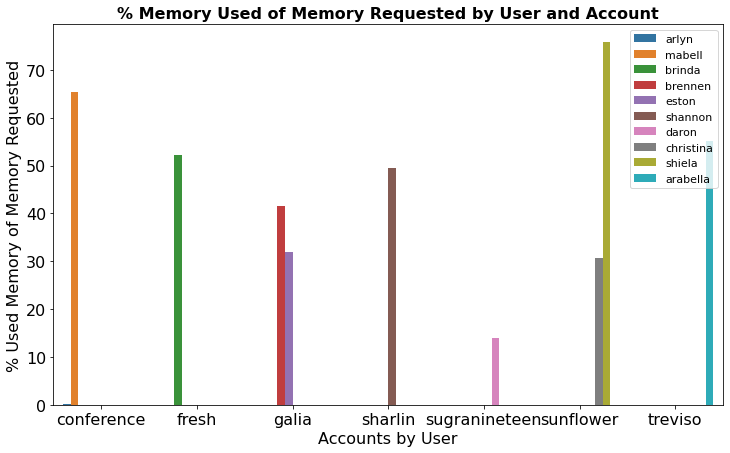

In [33]:
fontsize = 16

plt.figure(figsize = (12,7))
sns.barplot(x = 'ACCOUNT', y = '%USAGE', data = accre_acct_user, hue = 'USER')

plt.xticks(fontsize = fontsize)
plt.xlabel('Accounts by User', fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.ylabel('% Used Memory of Memory Requested', fontsize = fontsize)
plt.title('% Memory Used of Memory Requested by User and Account', fontsize = fontsize, fontweight = 'bold')
plt.legend(loc = 'upper right', fontsize = fontsize - 5);

In [36]:
accre_acct_avg = accre_prod_coi.groupby(['ACCOUNT']).sum().reset_index()

In [37]:
accre_acct_avg

,ACCOUNT,REQMEM_PER_CORE,USEDMEM_PER_CORE,REQTIME_SEC,USEDTIME_SEC,NODES,CPUS,OPTIMIZE,USEDMEM*TIMESEC,REQMEM*TIMESEC
0,conference,247552.000000,141144.770833,21772800.0,22018297.0,18,272,9.116211,1.739917e+11,3.032405e+11
1,fresh,18724.571429,9762.000000,1209600.0,1209620.0,1,7,0.521347,1.180831e+10,2.264962e+10
2,galia,161792.000000,64117.000000,74995200.0,75204504.0,62,62,22.845947,7.793679e+10,1.965592e+11
3,sharlin,163840.000000,81035.000000,9676800.0,9676949.0,8,40,3.956787,9.802145e+10,1.981839e+11
4,sugranineteen,24576.000000,3416.000000,6480000.0,10039042.0,6,6,0.833984,5.711033e+09,4.111992e+10
5,sunflower,19456.000000,10113.666667,4838400.0,4838488.0,4,48,2.578025,1.223371e+10,2.353445e+10
6,treviso,5120.000000,2825.625000,1188000.0,1522543.0,1,24,0.551880,4.302136e+09,7.795420e+09


In [40]:
var1 = accre_prod_coi.groupby('ACCOUNT').JOBID.nunique()
var1

ACCOUNT
conference       18
fresh             1
galia            62
sharlin           8
sugranineteen     6
sunflower         4
treviso           1
Name: JOBID, dtype: int64

In [44]:
accre_acct_avg['ACCT_%_AVG'] = (accre_acct_avg['USEDMEM*TIMESEC']/accre_acct_avg['REQMEM*TIMESEC']) / var1 * 100
accre_acct_avg

,ACCOUNT,REQMEM_PER_CORE,USEDMEM_PER_CORE,REQTIME_SEC,USEDTIME_SEC,NODES,CPUS,OPTIMIZE,USEDMEM*TIMESEC,REQMEM*TIMESEC,ACCT_%_AVG
0,conference,247552.000000,141144.770833,21772800.0,22018297.0,18,272,9.116211,1.739917e+11,3.032405e+11,NaN
1,fresh,18724.571429,9762.000000,1209600.0,1209620.0,1,7,0.521347,1.180831e+10,2.264962e+10,NaN
2,galia,161792.000000,64117.000000,74995200.0,75204504.0,62,62,22.845947,7.793679e+10,1.965592e+11,NaN
3,sharlin,163840.000000,81035.000000,9676800.0,9676949.0,8,40,3.956787,9.802145e+10,1.981839e+11,NaN
4,sugranineteen,24576.000000,3416.000000,6480000.0,10039042.0,6,6,0.833984,5.711033e+09,4.111992e+10,NaN
5,sunflower,19456.000000,10113.666667,4838400.0,4838488.0,4,48,2.578025,1.223371e+10,2.353445e+10,NaN
6,treviso,5120.000000,2825.625000,1188000.0,1522543.0,1,24,0.551880,4.302136e+09,7.795420e+09,NaN
